# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

from typing import Union
!pip install keras-flops
from keras_flops import get_flops

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

     |████████████████████████████████| 462 kB 13.9 MB/s 


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data loading

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [ ]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten,Input

In [ ]:
#@ test {"output": "ignore"}

### Build CNN teacher.###
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
cnn_model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same',
                     input_shape=(28, 28, 1)))

cnn_model.add(MaxPool2D(pool_size=(2, 2), strides=1))

cnn_model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))

cnn_model.add(MaxPool2D(pool_size=(2, 2), strides=2))

cnn_model.add(Flatten())

cnn_model.add(Dropout(rate=0.5))

cnn_model.add(Dense(activation='relu', units=128))

cnn_model.add(Dropout(rate=0.5))

cnn_model.add(Dense(units=10))



### Build fully connected student.###

fc_model = tf.keras.Sequential()

# your code start from here for step 2
fc_model.add(Input(shape=(28, 28, 1)))
fc_model.add(Flatten())

fc_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))


fc_model.add(Dense(activation='relu', units=784))


fc_model.add(Dense(units=10))

# Teacher loss function

In [ ]:
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=subclass_logits))

  return cross_entropy_loss_value

# Student loss function

In [ ]:
#@ test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 8. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/ temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)

  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits,
                      DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  return ALPHA*distillation_loss_value + (1-ALPHA)*cross_entropy_loss_value

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn,verbose = True):

  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    if verbose:
      print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
                 # your code start from here for step 4

        loss_value =  compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)[0]
    if verbose:
        print("Class_accuracy: " + '{:.2f}%'.format(
            num_correct / num_total * 100))
  
  print("Final Class_accuracy: " + '{:.2f}%'.format(
            num_correct / num_total * 100))
  return num_correct / num_total * 100

# Training models

## Training the teacher model

In [ ]:
train_and_evaluate(model=cnn_model,compute_loss_fn=compute_teacher_loss)

Epoch 1: Class_accuracy: 98.11%
Epoch 2: Class_accuracy: 98.73%
Epoch 3: Class_accuracy: 98.94%
Epoch 4: Class_accuracy: 98.96%
Epoch 5: Class_accuracy: 99.15%
Epoch 6: Class_accuracy: 99.08%
Epoch 7: Class_accuracy: 99.21%
Epoch 8: Class_accuracy: 99.10%
Epoch 9: Class_accuracy: 99.16%
Epoch 10: Class_accuracy: 99.24%
Epoch 11: Class_accuracy: 99.23%
Epoch 12: Class_accuracy: 99.21%
Final Class_accuracy: 99.21%


<tf.Tensor: shape=(), dtype=float32, numpy=99.21>

## Training the student model

### Student model fine tuning

In [ ]:
# your code start from here for step 5 
Test_Accuracies = []

best_accuracy = 0

for alp in np.linspace(0.5,0.9,5):
  Test_Accuracies_in_one_alp = []
  for temp in [1,2,4,16,32]:
    DISTILLATION_TEMPERATURE = temp
    ALPHA =alp
    print("Using Alpha {0}, Using Temperature {1}".format(alp, temp))
    
    fc_model = tf.keras.Sequential()
    fc_model.add(Input(shape=(28, 28, 1)))
    fc_model.add(Flatten())
    fc_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))
    fc_model.add(Dense(activation='relu', units=784))
    fc_model.add(Dense(units=10))

    accuracy = train_and_evaluate(model=fc_model,compute_loss_fn=compute_student_loss,verbose=False)
    Test_Accuracies_in_one_alp.append(accuracy)
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_alp = alp
      best_temp = temp
  Test_Accuracies.append(Test_Accuracies_in_one_alp)
print('The best aciracu after tunning is {0}, with ALPH = {1}, temperature = {2}'
    .format(best_accuracy, best_alp, best_temp))

Using Alpha 0.5, Using Temperature 1
Final Class_accuracy: 98.46%
Using Alpha 0.5, Using Temperature 2
Final Class_accuracy: 98.57%
Using Alpha 0.5, Using Temperature 4
Final Class_accuracy: 98.80%
Using Alpha 0.5, Using Temperature 16
Final Class_accuracy: 98.75%
Using Alpha 0.5, Using Temperature 32
Final Class_accuracy: 98.76%
Using Alpha 0.6, Using Temperature 1
Final Class_accuracy: 98.28%
Using Alpha 0.6, Using Temperature 2
Final Class_accuracy: 98.64%
Using Alpha 0.6, Using Temperature 4
Final Class_accuracy: 98.75%
Using Alpha 0.6, Using Temperature 16
Final Class_accuracy: 98.83%
Using Alpha 0.6, Using Temperature 32
Final Class_accuracy: 98.79%
Using Alpha 0.7, Using Temperature 1
Final Class_accuracy: 98.47%
Using Alpha 0.7, Using Temperature 2
Final Class_accuracy: 98.53%
Using Alpha 0.7, Using Temperature 4
Final Class_accuracy: 98.80%
Using Alpha 0.7, Using Temperature 16
Final Class_accuracy: 98.86%
Using Alpha 0.7, Using Temperature 32
Final Class_accuracy: 98.97%
Usin

In [ ]:
ALPHA = 0.6 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 2. #temperature hyperparameter
train_and_evaluate(model=fc_model,compute_loss_fn=compute_student_loss)

Epoch 1: Class_accuracy: 98.56%
Epoch 2: Class_accuracy: 98.72%
Epoch 3: Class_accuracy: 98.82%
Epoch 4: Class_accuracy: 98.81%
Epoch 5: Class_accuracy: 98.88%
Epoch 6: Class_accuracy: 98.95%
Epoch 7: Class_accuracy: 98.82%
Epoch 8: Class_accuracy: 98.82%
Epoch 9: Class_accuracy: 98.89%
Epoch 10: Class_accuracy: 98.84%
Epoch 11: Class_accuracy: 98.94%
Epoch 12: Class_accuracy: 98.85%
Final Class_accuracy: 98.85%


<tf.Tensor: shape=(), dtype=float32, numpy=98.85>

# Test accuracy vs. tempreture curve

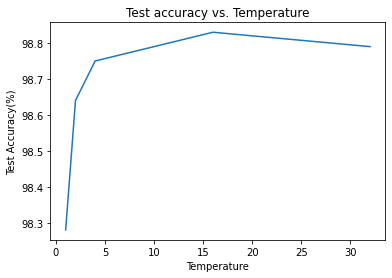

In [ ]:
# your code start from here for step 6
import matplotlib.pyplot as plt

plt.plot([1,2,4,16,32],Test_Accuracies[1])
plt.xlabel('Temperature')
plt.ylabel('Test Accuracy(%)')
plt.title('Test accuracy vs. Temperature')

plt.savefig('Temp vs Accuracy.svg',bbox_inches = 'tight')
plt.show()

# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7

fc_model_no_distillation.add(Input(shape=(28, 28, 1)))

fc_model_no_distillation.add(Flatten())

fc_model_no_distillation.add(Dense(activation='relu', units=784))


fc_model_no_distillation.add(Dense(activation='relu', units=784))


fc_model_no_distillation.add(Dense(units=10))

#@ test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  return cross_entropy_loss

In [ ]:
train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.92%
Epoch 2: Class_accuracy: 97.59%
Epoch 3: Class_accuracy: 97.74%
Epoch 4: Class_accuracy: 98.12%
Epoch 5: Class_accuracy: 97.88%
Epoch 6: Class_accuracy: 97.88%
Epoch 7: Class_accuracy: 98.08%
Epoch 8: Class_accuracy: 97.57%
Epoch 9: Class_accuracy: 98.19%
Epoch 10: Class_accuracy: 98.09%
Epoch 11: Class_accuracy: 98.07%
Epoch 12: Class_accuracy: 97.79%
Final Class_accuracy: 97.79%


<tf.Tensor: shape=(), dtype=float32, numpy=97.79>

# Comparing the teacher and student model (number of of parameters and FLOPs) 

## Teacher model

In [ ]:
# your code start from here for step 8
cnn_model.summary()
print('\nTeacher model FLOPs: ', get_flops(cnn_model, batch_size=1))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dropout (Dropout)           (None, 10816)             0

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`



Teacher model FLOPs:  30305354


## Student model with KD

In [ ]:
fc_model.summary()
print('\nStudent model with KF FLOPs: ', get_flops(fc_model, batch_size=1))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 dense_3 (Dense)             (None, 784)               615440    
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________

Student model with KF FLOPs:  2475882


## Student model without KD

In [ ]:
fc_model_no_distillation.summary()
print('\nStudent model without KF FLOPs: ', get_flops(fc_model_no_distillation, batch_size=1))

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 784)               0         
                                                                 
 dense_80 (Dense)            (None, 784)               615440    
                                                                 
 dense_81 (Dense)            (None, 784)               615440    
                                                                 
 dense_82 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________

Student model without KF FLOPs:  2475882


# XAI method to explain models

## Integrated gradients

In [ ]:
### Adapted From https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
import tensorflow as tf

def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

def compute_gradients(model, images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

  
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

def integrated_gradients(model, baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []
    
  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(model, baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)
      
  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [ ]:
@tf.function
def one_batch(model, baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(model, images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [ ]:
baseline = tf.zeros(shape=(28,28,1))

In [ ]:
#@title
def plot_img_attributions(model, baseline,
                          image,
                          target_class_idx,
                          m_steps=50):

  attributions = integrated_gradients(model, baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)


  return attribution_mask

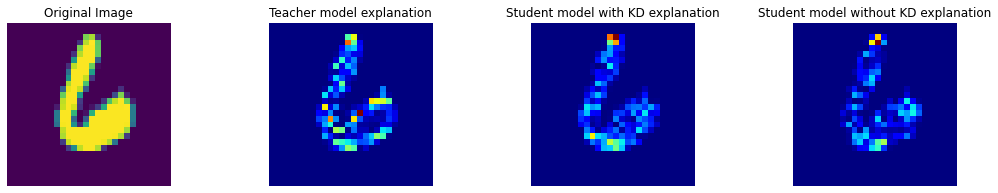

In [ ]:
for images, labels in mnist_train:
  image = images[0]
  teacher_explanation = plot_img_attributions(model = cnn_model, image=image, baseline=baseline, target_class_idx=np.argmax(cnn_model.predict(np.expand_dims(images[0], axis=0))), m_steps=240)
  student_KD_explanation = plot_img_attributions(model = fc_model, image=image, baseline=baseline, target_class_idx=np.argmax(cnn_model.predict(np.expand_dims(images[0], axis=0))), m_steps=240)
  student_no_KD_explanation = plot_img_attributions(model = fc_model_no_distillation, image=image, baseline=baseline, target_class_idx=np.argmax(cnn_model.predict(np.expand_dims(images[0], axis=0))), m_steps=240)

  fig, axs = plt.subplots(1,4, figsize=(18, 3))
  axs[0].imshow(np.array(images[0]).reshape(28,28))
  axs[0].set_title('Original Image')
  axs[1].imshow(teacher_explanation, cmap='jet')
  axs[1].set_title('Teacher model explanation')
  axs[2].imshow(student_KD_explanation, cmap='jet')
  axs[2].set_title('Student model with KD explanation')
  axs[3].imshow(student_no_KD_explanation, cmap='jet')
  axs[3].set_title('Student model without KD explanation')

  for i in range(4):
    axs[i].axis('off')
  plt.show()
  
  break

# Implementing the state-of-the-art KD algorithm

## Initialize Teacher-Assistant Model and Distill Teacher to TA

In [ ]:
# Define the TA Model


cnn_ta_model = tf.keras.Sequential()

cnn_ta_model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same',
                     input_shape=(28, 28, 1)))

cnn_ta_model.add(MaxPool2D(pool_size=(2, 2), strides=1))

cnn_ta_model.add(Flatten())

cnn_ta_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))

cnn_ta_model.add(Dropout(rate=0.5))

cnn_ta_model.add(Dense(units=10))

In [ ]:
def compute_TA_loss(images, labels):

  student_subclass_logits = cnn_ta_model(images, training=True)
  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits,
                      DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  return ALPHA*distillation_loss_value + (1-ALPHA)*cross_entropy_loss_value

In [ ]:
ALPHA = 0.1
DISTILLATION_TEMPERATURE = 2
train_and_evaluate(model=cnn_ta_model,compute_loss_fn=compute_TA_loss)

Epoch 1: Class_accuracy: 97.94%
Epoch 2: Class_accuracy: 98.41%
Epoch 3: Class_accuracy: 98.51%
Epoch 4: Class_accuracy: 98.66%
Epoch 5: Class_accuracy: 98.77%
Epoch 6: Class_accuracy: 98.75%
Epoch 7: Class_accuracy: 98.91%
Epoch 8: Class_accuracy: 98.93%
Epoch 9: Class_accuracy: 98.96%
Epoch 10: Class_accuracy: 99.02%
Epoch 11: Class_accuracy: 98.97%
Epoch 12: Class_accuracy: 99.02%
Final Class_accuracy: 99.02%


<tf.Tensor: shape=(), dtype=float32, numpy=99.02>

## Distill TA Model to Student Model

In [ ]:
def compute_student_loss_TA(images, labels):

  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  teacher_subclass_logits = cnn_ta_model(images, training=False)

  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits,
                      DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.


  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  return ALPHA*distillation_loss_value + (1-ALPHA)*cross_entropy_loss_value

In [ ]:
Test_Accuracies = []

best_accuracy = 0

for alp in np.linspace(0.5,0.9,5):
  Test_Accuracies_in_one_alp = []
  for temp in [1,2,4,16,32]:
    DISTILLATION_TEMPERATURE = temp
    ALPHA =alp
    print("Using Alpha {0}, Using Temperature {1}".format(alp, temp))
    
    fc_model = tf.keras.Sequential()
    fc_model.add(Input(shape=(28, 28, 1)))
    fc_model.add(Flatten())
    fc_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))
    fc_model.add(Dense(activation='relu', units=784))
    fc_model.add(Dense(units=10))

    accuracy = train_and_evaluate(fc_model,compute_student_loss_TA,verbose=False)
    Test_Accuracies_in_one_alp.append(accuracy)
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_alp = alp
      best_temp = temp
  Test_Accuracies.append(Test_Accuracies_in_one_alp)
print('The best aciracu after tunning is {0}, with ALPH = {1}, temperature = {2}'
    .format(best_accuracy, best_alp, best_temp))

Using Alpha 0.5, Using Temperature 1
Final Class_accuracy: 98.32%
Using Alpha 0.5, Using Temperature 2
Final Class_accuracy: 98.47%
Using Alpha 0.5, Using Temperature 4
Final Class_accuracy: 98.73%
Using Alpha 0.5, Using Temperature 16
Final Class_accuracy: 98.60%
Using Alpha 0.5, Using Temperature 32
Final Class_accuracy: 98.69%
Using Alpha 0.6, Using Temperature 1
Final Class_accuracy: 98.22%
Using Alpha 0.6, Using Temperature 2
Final Class_accuracy: 98.48%
Using Alpha 0.6, Using Temperature 4
Final Class_accuracy: 98.70%
Using Alpha 0.6, Using Temperature 16
Final Class_accuracy: 98.76%
Using Alpha 0.6, Using Temperature 32
Final Class_accuracy: 98.68%
Using Alpha 0.7, Using Temperature 1
Final Class_accuracy: 98.19%
Using Alpha 0.7, Using Temperature 2
Final Class_accuracy: 98.59%
Using Alpha 0.7, Using Temperature 4
Final Class_accuracy: 98.70%
Using Alpha 0.7, Using Temperature 16
Final Class_accuracy: 98.70%
Using Alpha 0.7, Using Temperature 32
Final Class_accuracy: 98.72%
Usin